Original data available at:

https://www.kaggle.com/snap/amazon-fine-food-reviews

In [1]:
%matplotlib inline
%load_ext autotime
import sys
sys.path.append('../src/')

In [530]:
from typing import Tuple, Sequence, Dict, Callable, Any, List, Pattern, Union, Iterable, overload, Optional
from tqdm.autonotebook import tqdm

from functools import partial
import nltk
from nltk.tokenize import TreebankWordTokenizer, PunktSentenceTokenizer
from nltk.tokenize.stanford import StanfordTokenizer
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag_sents, pos_tag
import re
import datetime
import os
import zipfile

from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Lock
import random, statistics
import toolz as tz
import toolz.curried as tzc

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing as pp
from sklearn import (feature_extraction, decomposition, linear_model, svm, model_selection, metrics)
from sklearn.pipeline import make_pipeline, make_union
from pattern import en as pattern_en
from pattern.web import plaintext
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
import numpy as np
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

import spacy

from utils.preprocessing import (create_corpus_processor, filter_stopwords, clean_html, QUOTES_PATTERN, PARENTHESIS_PATTERN,
                                get_curated_english_contractions, filter_stopwords, RegexpReplacer, CorpusNormalizer)
from utils.nn import (ScoreScaler, create_embedding_matrix, load_word_vectors, predict_scores, ModelWrapper, train_fasttext)
from utils.corpus import Corpus
from utils.evaluate import evaluate_prediction, save_report

sns.set()

time: 11.9 ms


In [529]:
FORCE_RELOAD = False

DATADIR = Path('../data/')
MODELS_DIR = Path('../models/')

TMPDIR = Path('../tmp')
ARTEFACT_DIR = Path('../artefacts/')
REPORTS_DIR = Path('../reports/')

TRAIN_DATASET_FILE = DATADIR / 'Reviews-train.csv.gzip'
TEST_DATASET_FILE = DATADIR / 'Reviews-test.csv.gzip'

time: 13.3 ms


### Create Train/Test split
We reserve 10% of the dataset for testing.

In [4]:

if not (TRAIN_DATASET_FILE.exists() and TEST_DATASET_FILE.exists()):
    print('Building train/test split.')
    rawdataset = pd.read_csv(DATADIR / 'Reviews.csv', index_col=0)
    train, test = train_test_split(rawdataset, test_size=0.10)
    print(f'shape of training data: {train.shape}')
    train.to_csv(TRAIN_DATASET_FILE, compression='gzip')
    print(f'shape of testing data: {test.shape}')
    test.to_csv(TEST_DATASET_FILE, compression='gzip')
else:
    print('train/test split exists. Loading training data.')
    rawdataset = pd.read_csv(TRAIN_DATASET_FILE, compression='gzip', index_col=0)
    print(f'shape of dataset data: {rawdataset.shape}')

train/test split exists. Loading training data.
shape of dataset data: (511608, 9)
time: 4.84 s


## Exploratory Data Analysis

In [447]:
rawdataset.sample(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
132844,B000ER5DCY,AWBKE3QTB3BWX,Nessie,1,1,4,1315958400,My baby's favorite 2nd stage food so far and g...,I like the Earth's Best baby food line because...
252371,B0001M0YBW,A2WUI7LDTN2ID4,Jodi,2,2,5,1308441600,Miracles Happen!!!,I sent this tea out of seas to a relative with...
521377,B007JFXWRC,A91TB0WX94MHP,Carina,0,0,5,1348704000,Made with real blackberries! Tastes real good,"I am an avid drinker of lipton black tea, I dr..."


time: 88.6 ms


In [448]:
rawdataset.describe(include=['O'])

,ProductId,UserId,ProfileName,Summary,Text
count,511608,511608,511594,511582,511608
unique,71053,238161,203824,271921,359839
top,B007JFMH8M,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",Delicious!,"This review will make me sound really stupid, ..."
freq,827,410,413,2239,185


time: 9.39 s


In [449]:
rawdataset.describe(exclude=['O'])

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,511608.000000,511608.000000,511608.000000,5.116080e+05
mean,1.746491,2.232741,4.183232,1.296241e+09
std,7.762385,8.413478,1.310201,4.803743e+07
min,0.000000,0.000000,1.000000,9.393408e+08
25%,0.000000,0.000000,4.000000,1.271290e+09
50%,0.000000,1.000000,5.000000,1.311120e+09
75%,2.000000,2.000000,5.000000,1.332720e+09
max,866.000000,923.000000,5.000000,1.351210e+09


time: 225 ms


This analysis will focus on predicting the score of the review. Let's start by dropping the columns we're not going to use.
Note that this dataset could be used to train a recommendation engine thanks to the ProductId/UserId provided.

In [450]:
eda_dataset = rawdataset.drop(['ProductId', 'UserId', 'Time', 'ProfileName'], axis=1)
eda_dataset['SummaryLength'] = eda_dataset['Summary'].str.len()
eda_dataset['TextLength'] = eda_dataset['Text'].str.len()

time: 344 ms


In [454]:
eda_dataset[['Score', 'Summary']].sample(3)

,Score,Summary
Id,,
549996,4,Tastes may vary
474228,4,"Good, but these cans are BIG."
311078,5,How good Amazon Shipment be more tender


time: 31.7 ms


In [455]:
eda_dataset[['Score', 'Text']].sample(3)

,Score,Text
Id,,
244968,5,I used to buy Lactose-free milk from the Super...
382646,5,Although I didn't actually get to enjoy these ...
217850,4,I have tried several of the Stash herbal teas ...


time: 43.9 ms


In [456]:
eda_dataset_by_scores = eda_dataset.groupby('Score')

time: 1.14 ms


In [457]:
eda_dataset_by_scores[['SummaryLength', 'TextLength']].describe()

SummaryLength                                                      \
              count       mean        std  min   25%   50%   75%    max   
Score                                                                     
1           46997.0  24.466030  15.302695  1.0  13.0  21.0  32.0  128.0   
2           26779.0  24.889391  14.601783  1.0  14.0  22.0  33.0  128.0   
3           38443.0  26.086102  15.158867  1.0  15.0  23.0  34.0  127.0   
4           72578.0  24.839290  14.754415  1.0  14.0  22.0  33.0  128.0   
5          326785.0  22.552235  13.366505  1.0  13.0  20.0  29.0  128.0   

      TextLength                                                              
           count        mean         std   min    25%    50%    75%      max  
Score                                                                         
1        46997.0  478.542184  520.123653  12.0  202.0  339.0  564.0  11861.0  
2        26803.0  490.476775  456.281301  33.0  212.0  358.0  606.0   9295.0  
3        38445.0  520.681129  512.352307  32.0  214.0  373.0  656.0  21409.0  
4        72578.0  496.934030  486.023788  35.0  196.0  347.0  623.0  12518.0  
5       326785.0  402.671197  411.328065  18.0  170.0  277.0  481.0  16952.0

time: 273 ms


Good reviews are shorter on average.

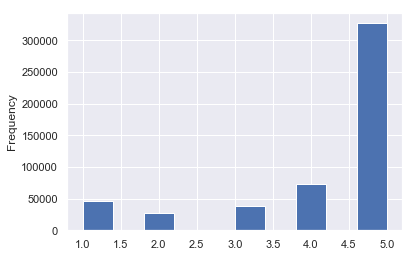

time: 382 ms


In [458]:
eda_dataset['Score'].plot('hist')

Perfect scores are overreppresented. We're in presence of a fairly imbalanced dataset.

In [464]:
def get_sample_reviews(dataset, label=None, n=5):
    for _ in range(n):
        summary = dataset['Summary'].sample().values[0]
        text = dataset['Text'].sample().values[0]
        print('\n')
        print('-' * 100)
        if label:
            print(label)
        print('Summary:', summary)
        print(text)
        

time: 1.82 ms


In [467]:
for i in range(1, 6):
    print('\n')
    print('=' * 100)
    print('Score: ', i)
    print('=' * 100)
    get_sample_reviews(eda_dataset_by_scores.get_group(i), n=1)




Score:  1


----------------------------------------------------------------------------------------------------
Summary: HORRIBLE change to the original orgain
This tea is horrible. The product has a dirty laundry smell and does not taste much better. I expected better from something so expensive. It is simply not worth it. Cheaper white teas from other brands are much better. Rishi, H&S, and numerous other tea companies have better white tea. In all honesty, this tastes worse than bagged tea. Teavana has some good products, but they are just too overpriced.<br /><br />Did I mention how horrible Teavana's customer service is? They don't respond to emails,etc. You have to wait on the phone for hours. Simply unacceptable. Feel free to check their facebook wall to see customers voicing the same concern.


Score:  2


----------------------------------------------------------------------------------------------------
Summary: Hot water
Just recently purchase as I like the soda taste but

Observations:
* html tags are still present.
* Some english contractions still present.

In [468]:
eda_dataset['Text'] = eda_dataset['Text'].apply(plaintext)

time: 51.8 s


In [469]:
get_sample_reviews(eda_dataset, n=2)



----------------------------------------------------------------------------------------------------
Summary: Issues Resolved In Second Basket
Butter Pecan is my favorite brand of coffee! Each bag brews a wonderful pot of freshly made coffee. Each 1.5 ounce packet is favor sealed with freshness that you can smell the moment you open the packet.


----------------------------------------------------------------------------------------------------
Summary: Horrible...liquid Red Hots
Really? Who blends this stuff and decides that it is good? Ugh. I can sum this nastyness up in one quick phrase. Stale airline coffee! If you like that flavor, then you will love this one, if you don't like thin cardboard soaked, never washed the pot out, and the water came from a tin canteen, flavored coffee, then you won't like this one either! I would give this zero stars if I could. WOW, likely the worst cup of coffee that I have ever had. I hope Wolfy reads this as his name is on the package and I expe

### EDA - Preprocessing

We're going to tokenize and stem the dataset to have a look at the distribution of tokens by scores.
Note that we do not use spacy for the sake of the exercise.

A first pass over the data reveal that stopwords and punctuation are significantly poluting the dataset. We'll remove them first

In [20]:

class DocumentStemmer:
    def __init__(self, stopwords, lower=True):
        self._stemmer = PorterStemmer()
        self._stopwords = stopwords
        self._lower = lower
        sent_tokenizer = PunktSentenceTokenizer()
        word_tokenizer = TreebankWordTokenizer()
        self._tokenize_text = tzc.compose(tzc.mapcat(word_tokenizer.tokenize), sent_tokenizer.tokenize)
        
    def stem_document(self, doc):
        if self._lower:
            doc = doc.lower()
        tokens = self._tokenize_text(doc)
        stems = [self._stemmer.stem(w) for w in tokens if w not in self._stopwords]
        return stems
        

time: 2.08 ms


In [21]:
STOPWORDS = {'.', ',', "''", '``', '(', ')'}.union(stopwords.words('english'))

time: 10.6 ms


In [22]:

doc_stemmer = DocumentStemmer(STOPWORDS)

time: 899 µs


In [23]:
with ProcessPoolExecutor() as executor:
    stems = list(executor.map(doc_stemmer.stem_document, eda_dataset['Text'], chunksize=1000))
    

time: 3min 9s


In [24]:
eda_dataset['Stems'] = stems

time: 469 ms


In [25]:
eda_dataset_by_scores = eda_dataset.groupby('Score')

time: 215 ms


In [33]:
def show_most_common(counter, title=None, n=25):
    most_common = reversed(counter.most_common(n))
    k, v = zip(*most_common)
#     fig = plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.barh(k, v);



time: 1.35 ms


In [27]:
counters = {
    name: Counter(tz.concat(df['Stems']))
    for name, df in eda_dataset_by_scores
}


time: 3.13 s


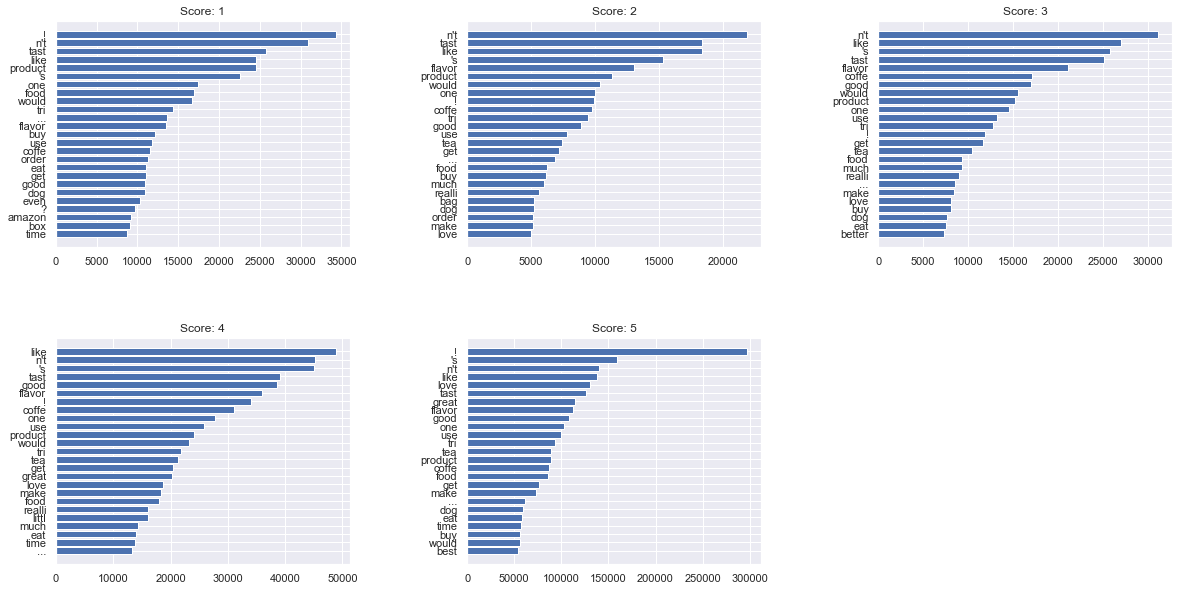

time: 1.55 s


In [36]:
#TODO: Create word cloud and attempt to identify some pattern.
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, (score, counter) in enumerate(counters.items()):
    ax = fig.add_subplot(2, 3, i+1)
    show_most_common(counter, f'Score: {score}')

## Raw Dataset

In [10]:
features_train, features_devtest, scores_train, scores_devtest = train_test_split(rawdataset.drop('Score', axis=1), 
                                                                                  rawdataset['Score'], 
                                                                                  test_size=0.25, stratify=rawdataset['Score'])
X = features_train['Text']
X_devtest = features_devtest['Text']
print(f'train: {features_train.shape}\ndevtest: {features_devtest.shape}')

train: (383706, 8)
devtest: (127902, 8)
time: 566 ms


In [11]:
X_sampled, _, y_sampled, _ = train_test_split(X, scores_train, train_size=0.5, stratify=scores_train) 
print(f'sample size: {X_sampled.shape}')

sample size: (191853,)
time: 204 ms


## Modelling

### Modelling - Baseline Model

We start with a baseline model applying LSA to the dataset with no additional features.
We'll test a few different model types with this simple feature set.

In [45]:
def make_baseline(estimator):
    baseline = make_pipeline(
        feature_extraction.text.TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1, 2)),
        decomposition.TruncatedSVD(n_components=300, n_iter=8),
        estimator
    )
    
def evaluate_baseline(baseline, X, y, X_test, y_test, label=None):
    tranforms = make_pipeline(
        feature_extraction.text.TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1, 2)),
        decomposition.TruncatedSVD(n_components=300, n_iter=8)
    )
    X_tf = tranforms.fit_transform(X)
    
    print(f'training {baseline} done.')
    print('evaluating...')
    y_pred = baseline.predict(X_test)
    report = evaluate_prediction(y_test, y_pred)
    if label:
        label = f'baseline-{label}'
    else:
        label = 'baseline'
    save_report(report, REPORTS_DIR, label)
    return baseline, report


time: 4.3 ms


In [46]:
baselines = {
    'logit-ovr': linear_model.LogisticRegression(solver='saga', multi_class='ovr', n_jobs=-1, max_iter=250),
    'logit-multinomial': linear_model.LogisticRegression(solver='saga', multi_class='multinomial', n_jobs=-1, max_iter=250),
}

time: 3.84 ms


In [209]:
def evaluate_baseline(estimator, feature_extractor, X_train, y_train, X_test, y_test, label=None):
    X = feature_extractor.transform(X_train)
    estimator.fit(X, y_train)

    baseline = make_pipeline(*feature_extractor.named_steps.values(), estimator)
    
    print(f'fitting {label or baseline} done. evaluating...')
    
    y_pred = baseline.predict(X_test)
    report = evaluate_prediction(y_test, y_pred)
    if label:
        label = f'baseline-{label}'
    else:
        label = 'baseline'
    save_report(report, REPORTS_DIR, label)
    return baseline, report


def evaluate_baselines(baselines, X_train, y_train, X_test, y_test):
    lsa = make_pipeline(
        feature_extraction.text.TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1, 2)),
        decomposition.TruncatedSVD(n_components=300, n_iter=8)
    )
    lsa.fit(X_train)
    print('feature extraction done.')
    
    with ProcessPoolExecutor() as executor:
        future_to_labels = {
            executor.submit(evaluate_baseline, baseline, lsa, X_train, y_train, X_test, y_test, label): label
            for label, baseline in baselines.items()
        }
    
    results = {}
    for future in as_completed(future_to_labels):
        label = future_to_labels[future]
        result = future.result()
        print(result)
        if isinstance(result, tuple):
            model, report = result
            result[label] = {'model': model, 'report': report}
        else:
            print(f'issue with {label}')

    return results

    



feature extraction done.
fitting logit-multinomial done. evaluating...
AUROC: 0.614
MCC: 0.365
              precision    recall  f1-score   support

           1       0.55      0.54      0.54     11749
           2       0.33      0.05      0.09      6701
           3       0.36      0.14      0.20      9611
           4       0.46      0.14      0.22     18145
           5       0.74      0.96      0.84     81696

   micro avg       0.70      0.70      0.70    127902
   macro avg       0.49      0.37      0.38    127902
weighted avg       0.63      0.70      0.63    127902



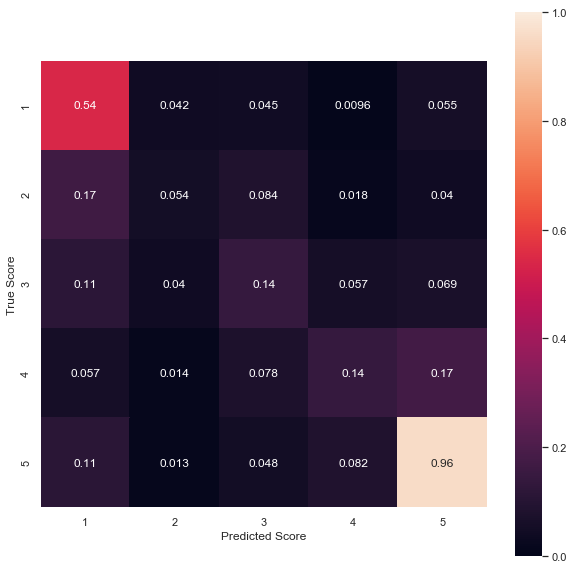

fitting logit-ovr done. evaluating...
AUROC: 0.601
MCC: 0.347
              precision    recall  f1-score   support

           1       0.56      0.50      0.53     11749
           2       0.36      0.03      0.05      6701
           3       0.37      0.10      0.16      9611
           4       0.42      0.14      0.21     18145
           5       0.73      0.97      0.83     81696

   micro avg       0.69      0.69      0.69    127902
   macro avg       0.49      0.35      0.35    127902
weighted avg       0.62      0.69      0.62    127902



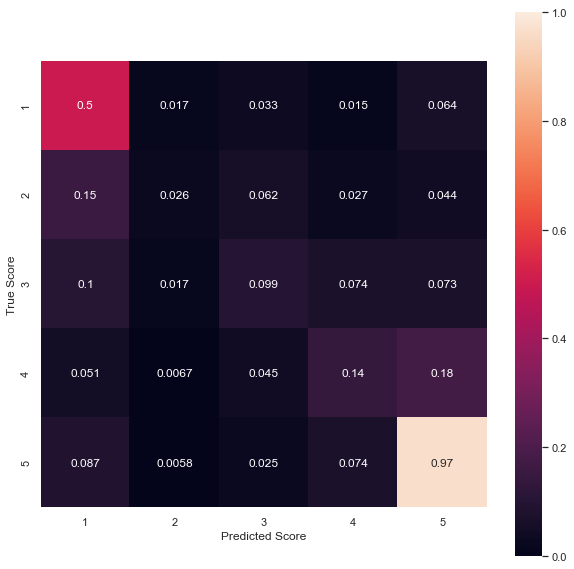

(Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smoot...penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False))]), {'auroc': 0.6005091256480368, 'f1score': 0.3542407767902014, 'normalized_confusion_matrix': [[0.49655289811898884, 0.016713923295030592, 0.03267089792945583, 0.014549462661890328, 0.06395661966314141], [0.1539705506851647, 0.0261155051484853, 0.061596087816044115, 0.027280242491044365, 0.04443301997649824], [0.10324282917695123, 0.016564691837039246, 0.09863697846217875, 0.07406999173325986, 0.07338180571876224], [0.05072772150821347, 0.006715415609610506, 0.04536468629695141, 0.1393772389087903, 0.17796464943204074], [0.08690101285215764, 0.005820026861662438

TypeError: 'tuple' object does not support item assignment

In [210]:
results = evaluate_baselines(baselines, X_sampled, y_sampled, X_devtest, scores_devtest)

## Corpus Preparation

In [12]:
ENGLISH_CONTRACTIONS = get_curated_english_contractions(ARTEFACT_DIR / 'curated_contractions.csv')
STANFORD_POSTAGGER_JAR = str(ARTEFACT_DIR / 'stanford-postagger/stanford-postagger.jar')
STANFORD_POSTAGGER_OPTIONS = dict(normalizeParentheses=False, normalizeFractions=True, normalizeOtherBrackets=False, splitHyphenated=True)


quote_remover = RegexpReplacer(QUOTES_PATTERN)
hyphen_replacer = RegexpReplacer([('-', ' ')])
parenthesis_remover = RegexpReplacer(PARENTHESIS_PATTERN)
contraction_replacer = RegexpReplacer(ENGLISH_CONTRACTIONS)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
sent_tokenizer = PunktSentenceTokenizer()
word_tokenizer = TreebankWordTokenizer()
stanford_tokenizer = StanfordTokenizer(STANFORD_POSTAGGER_JAR, options=STANFORD_POSTAGGER_OPTIONS)
tokenize_text = tzc.compose(tzc.mapcat(stanford_tokenizer.tokenize), sent_tokenizer.tokenize)
lower_tokens = tzc.map(str.lower)

time: 2.94 ms


In [514]:
def spellcheck_token(token: str) -> str:
    if token in word_vectors:
        return token
    
    suggestions = pattern_en.suggest(token)
    correction: str
    if suggestions[0][1] >= 0.95:
        correction = suggestions[0][0]
    else:
        correction = token
        
    return token

def strip_token(token: str) -> str:
    return token.strip('.*_-\'\"')

def split_token(token: str) -> str:
    '''
    Splits a token in its part based on a separation character.
    '''
    patterns = ['.', '-', '*', '/', '\\']
    for pattern in patterns:
        token.split()

            
def save_sentences(path: Union[str, Path], sentences):
    '''
    Writes sentes to file to make embedding model training faster.
    '''
    with open(path, 'wt') as f:
        for sent in tqdm(sentences):
            f.write(sent)
            f.write('\n')


    


time: 5.62 ms


### Normalization and Parsing

In [16]:
normalizer = CorpusNormalizer(contraction_replacer, clean_html)
nlp = spacy.load('en_core_web_sm', disable=('ner'))
batch_size = 2000


time: 149 ms


In [19]:
def parse_corpus(texts, index=None, path=None, batch_size=1000) -> Corpus:
    print('parsing training set...')
    if index is None:
        index = range(len(corpus))
        
    normalized_texts = normalizer.transform(texts)
    indexed_texts = zip(normalized_texts, index)
    indexed_parsed_docs = [doc for doc in tqdm(nlp.pipe(indexed_texts, as_tuples=True, batch_size=batch_size), total=len(texts))]
    print('done.')
    
    corpus = Corpus(nlp, indexed_documents=indexed_parsed_docs)
    if path:
        print(f'saving corpus to {path}')
        corpus.save(path)
        print('done.')

    return corpus

time: 2.35 ms


#### Training Corpus

In [20]:
train_save_path = ARTEFACT_DIR / 'train_corpus.zip'
if train_save_path.exists() and not FORCE_RELOAD:
    train_corpus = Corpus.load(nlp, train_save_path)
else:
    train_corpus = parse_corpus(X, X.index, train_save_path, batch_size)
    
word_count = train_corpus.count_words()
print(f'{word_count} word in corpus')

parsing training set...


done.
saving corpus to ../artefacts/train_corpus.zip
done.
35833002 word in corpus
time: 46min 13s


In [513]:
print('saving training sentences to disk...')
corpus_file = TMPDIR / 'train_sentences.txt'
save_sentences(corpus_file, train_corpus.sentences_generator())
print('done.')

saving training sentences to disk...
done.
time: 59.8 s


#### Validation Corpus

In [24]:
devtest_save_path = ARTEFACT_DIR / 'devtest_corpus.zip'
if devtest_save_path.exists() and not FORCE_RELOAD:
    devtest_corpus = Corpus.load(nlp, devtest_save_path)
else:
    devtest_corpus = parse_corpus(X_devtest, X_devtest.index, devtest_save_path, batch_size)

word_count = train_corpus.count_words()
print(f'{word_count} word in corpus')

parsing training set...


done.
saving corpus to ../artefacts/devtest_corpus.zip
done.
time: 15min 26s


### Training Fasttext

In [25]:
size = 300
epochs = 10

vector_model_file = (MODELS_DIR / f'fasttext/fasttext-{size}.model').as_posix()

if os.path.exists(vector_model_file) and not FORCE_RELOAD:
    print('loading FastText model from disk...')
    vector_model = FastText.load(vector_model_file)
else:
    print(f'training FastText-{size} for {epochs} epochs')
    vector_model = train_fasttext(corpus_file.as_posix(), total_words=word_count, size=size, window=5, epochs=epochs)
    print('done')

    print('saving FastText model to disk...')
    vector_model.save(vector_model_file)

print('done.')

training FastText-300 for 10 epochs


W0511 00:05:48.300411 140735669322624 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


done
saving FastText model to disk...


W0511 00:41:33.470665 140735669322624 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


done.
time: 36min 14s


## Modelling - DNN

In [26]:
!ls $DATADIR

Reviews-test.csv.gzip        raw_contractions.csv
Reviews-train.csv.gzip       raw_contractions.txt
Reviews.csv                  sampleSubmission.csv
amazon-fine-food-reviews.zip testData.tsv
hashes.txt                   unlabeledTrainData.tsv
labeledTrainData.tsv
time: 253 ms


In [254]:
word_tokenizer = Tokenizer(oov_token='<UNK>', lower=False)
pos_tags_tokenizer = Tokenizer(oov_token='<UNK>', lower=False)

time: 1.14 ms


In [517]:
word_tokenizer.fit_on_texts(train_corpus.texts_generator())
pos_tags_tokenizer.fit_on_texts(train_corpus.pos_tags_generator())

tokenizers = {
    'word': word_tokenizer,
    'pos_tags': pos_tags_tokenizer
}

time: 1min 15s


In [518]:
word_embedding_matrix = create_embedding_matrix(word_tokenizer.word_index, vector_model.wv)
print(word_embedding_matrix.shape)

(141158, 300)
time: 13.4 s


In [32]:
miss = word_embedding_matrix.sum(axis=1) == 0
miss_idx = np.where(miss)[0]
embedding_coverage = 1 - miss.sum() / word_embedding_matrix.shape[0]
print(f'embedding coverage: {embedding_coverage}')

embedding coverage: 0.9999906332836898
time: 83.5 ms


In [33]:
missed_words = [word_tokenizer.index_word[i] for i in miss_idx[1:]]
len(missed_words)

0

time: 4.42 ms


In [223]:
def get_callbacks(label: str) -> List[Callback]:
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=7, 
                                   verbose=0, 
                                   mode='auto', 
                                   restore_best_weights=True)
    
    checkpoint_path = MODELS_DIR / label / 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'
    if not checkpoint_path.parent.exists():
        checkpoint_path.parent.mkdir()
        
    checkpoint = ModelCheckpoint(checkpoint_path.as_posix(), period=3, save_best_only=True, save_weights_only=True)
    
    reduce_lr = ReduceLROnPlateau(patience=5)
    
    log_path = MODELS_DIR / label / 'logs/fit' / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    if not log_path.exists():
        log_path.mkdir(parents=True)
        
    tensorboard = TensorBoard(log_dir=log_path.as_posix(), histogram_freq=1)

    return [early_stopping, checkpoint, reduce_lr, tensorboard]

time: 2.72 ms


##### Simple Model

In [522]:
class SimpleModel(ModelWrapper):
    '''
    A Simple Dense block. Acts as a baseline within the different architectures.
    '''
    def __init__(self, tokenizers: dict, embedding_matrix: np.ndarray, maxlen: int, use_softmax: bool = True, class_weight: dict = None):
        super().__init__(tokenizers, use_softmax, class_weight)
        self.embedding_matrix = embedding_matrix
        self.maxlen = maxlen
        self.name: str
        if self.use_softmax:
            self.name = 'simple-dnn-softmax'
        else:
            self.name = 'simple-dnn-sigmoid'
            
    def _compile(self):
        embedding_shape = self.embedding_matrix.shape
        model = Sequential(name=self.name)
        model.add(layers.Embedding(embedding_shape[0], embedding_shape[1], input_length=self.maxlen))
        model.add(layers.Flatten())
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        
        final_layer: layers.Layer
        if self.use_softmax:
            final_layer = layers.Dense(5, activation='softmax')
            loss = 'sparse_categorical_crossentropy'
            eval_metrics = ['acc']
        else:
            final_layer = layers.Dense(1, activation='sigmoid')
            loss = 'mse'
            eval_metrics = ['mae']

        model.add(final_layer)

        model.layers[0].set_weights([self.embedding_matrix])
        model.layers[0].trainable = False
        model.compile(optimizer='adam', loss=loss, metrics=eval_metrics)
        model.summary()

        return model

    def text_to_padded_sequences(self, corpus: Corpus) -> Iterable:
        word_sequences = pad_sequences(self.tokenizers['word'].texts_to_sequences(corpus.texts()), maxlen=self.maxlen)
        return word_sequences

time: 5.84 ms


###### Conv1D Model

In [523]:
class Conv1DModel(ModelWrapper):
    '''
    Uses a convolutional layer to gain some context awareness on the text.
    '''
    def __init__(self, tokenizers: dict, embedding_matrix: np.ndarray, maxlen: int, use_softmax: bool = True, class_weight: dict = None):
        super().__init__(tokenizers, use_softmax, class_weight)
        self.use_softmax = use_softmax
        self.class_weight = class_weight
        self.embedding_matrix = embedding_matrix
        self.maxlen = maxlen
        self._score_scaler = ScoreScaler()
        
        self.name: str
        if self.use_softmax:
            self.name = 'conv1d-dnn-softmax'
        else:
            self.name = 'conv1d-dnn-sigmoid'
            
    def _compile(self):
        embedding_shape = self.embedding_matrix.shape
        

        
        model = Sequential(name=self.name)
        model.add(layers.Embedding(embedding_shape[0], embedding_shape[1], input_length=self.maxlen))
        model.add(layers.SeparableConv1D(32, 9, activation='relu'))
        model.add(layers.MaxPool1D(5))
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(0.5))    
        
        final_layer: layers.Layer
        if self.use_softmax:
            name = 'conv1d-dnn-softmax'
            final_layer = layers.Dense(5, activation='softmax')
            loss = 'sparse_categorical_crossentropy'
            eval_metrics = ['acc']
        else:
            name = 'conv1d-dnn-sigmoid'
            final_layer = layers.Dense(1, activation='sigmoid')
            loss = 'mse'
            eval_metrics = ['mae']
            
        model.add(final_layer)

        model.layers[0].set_weights([self.embedding_matrix])
        model.layers[0].trainable = False
        model.compile(optimizer='adam', loss=loss, metrics=eval_metrics)
        model.summary()

        return model
    
    def text_to_padded_sequences(self, corpus: Corpus) -> Iterable:
        word_sequences = pad_sequences(self.tokenizers['word'].texts_to_sequences(corpus.texts()), maxlen=self.maxlen)
        return word_sequences
    

time: 4.91 ms


##### Linguistic Feature aware model


In [524]:
class LinguisticAwareModel(ModelWrapper):
    '''
    A models that can take advantage of more linguistic features, such as POS tags
    '''
    def __init__(self,
                 tokenizers: dict,
                 word_embeddings_matrix: np.ndarray,
                 pos_tags_embedding_shape: Tuple[int, int],
                 maxlen: int,
                 use_softmax: bool = True,
                 class_weights: dict = None):
        super().__init__(tokenizers, use_softmax, class_weight)
        self.word_embeddings_matrix = word_embeddings_matrix
        self.pos_tags_embedding_shape = pos_tags_embedding_shape
        self.maxlen = maxlen
        self._score_scaler = ScoreScaler()
    
        self.name: str
        if self.use_softmax:
            self.name = 'linguistic-dnn-softmax'
        else:
            self.name = 'linguistic-dnn-sigmoid'

    def _compile(self):
        word_embedding_shape = self.word_embeddings_matrix.shape
        words_input = layers.Input(name='words', shape=(self.maxlen,))
        pos_tags_input = layers.Input(name='pos_tags', shape=(self.maxlen,))

        word_embeddings = layers.Embedding(*word_embedding_shape, name='word_embeddings', weights=[word_embedding_matrix])
        word_embeddings.trainable = False

        pos_tags_embeddings = layers.Embedding(*self.pos_tags_embedding_shape, name='pos_tags_embeddings')

        words_x = word_embeddings(words_input)
        pos_tags_x = pos_tags_embeddings(pos_tags_input)

        x = layers.concatenate([words_x, pos_tags_x])
        x = layers.SeparableConv1D(32, 9, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool1D(5)(x)
        x = layers.Flatten()(x)
    #     x = layers.Dense(256, activation='relu')(x)
    #     x = layers.BatchNormalization()(x)
    #     x = layers.Dropout(0.5)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        if self.use_softmax:
            outputs = layers.Dense(5, activation='softmax')(x)
            loss = 'sparse_categorical_crossentropy'
            eval_metrics = ['acc']
        else:
            outputs = layers.Dense(1, activation='sigmoid')(x)
            loss = 'mse'
            eval_metrics = []

        model = Model(name=name, inputs=[words_input, pos_tags_input], outputs=outputs)

        model.compile(optimizer='adam', loss=loss, metrics=eval_metrics)
        model.summary()

        return model
    
    def text_to_padded_sequences(self, corpus: Corpus) -> Iterable:
        word_sequences = pad_sequences(self.tokenizers['word'].texts_to_sequences(corpus.texts()), maxlen=self.maxlen)
        pos_tags_sequences = pad_sequences(self.tokenizers['pos_tags'].texts_to_sequences(corpus.pos_tags()), maxlen=self.maxlen)
        return {'words': word_sequences, 'pos_tags': pos_tags_sequences}
    

time: 5.93 ms


In [368]:
q = 90
doc_lengths = np.array([len(doc) for doc, i in parsed_train_corpus])
p = np.percentile(doc_lengths, q)
print(f'{q}% of the documents are at most {p} words. We\'ll limit us to this maxlen for our classifiers sequences')

90% of the documents are at most 188.0 words. We'll limit us to this maxlen for our classifiers sequences
time: 3.11 s


In [369]:
pos_tags_embedding_size = 16
count_pos_tags = len(pos_tags_tokenizer.index_word) + 1
pos_tags_embedding_shape = (count_pos_tags, pos_tags_embedding_size)
pos_tags_embedding_shape

(52, 16)

time: 2.45 ms


In [526]:
maxlen = 250
epochs = 40
batch_size = 128
validation_split = 0.1
use_softmax = True


# Used with softmax
class_weight = {
    0: 1,
    1: 3,
    2: 5,
    3: 3,
    4: 1
}

time: 1.98 ms


In [525]:
choice = 'conv1d'
model = {
    'simple': SimpleModel(tokenizers, word_embedding_matrix, maxlen, use_softmax=use_softmax, class_weight=class_weight),
    'conv1d': Conv1DModel(tokenizers, word_embedding_matrix, maxlen, use_softmax=use_softmax, class_weight=class_weight),
    'linguistic': LinguisticAwareModel(tokenizers, word_embedding_matrix, pos_tags_embedding_shape, maxlen, use_softmax=use_softmax, class_weights=class_weights)
}[choice]
model.compile()

Model: "conv1d-dnn-softmax"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_63 (Embedding)     (None, 250, 300)          42347400  
_________________________________________________________________
separable_conv1d_38 (Separab (None, 242, 32)           12332     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 48, 32)            0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 1536)              0         
_________________________________________________________________
dense_150 (Dense)            (None, 128)               196736    
_________________________________________________________________
dropout_87 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_151 (Dense)            (None, 64)         

time: 1.78 s


In [528]:
x_train_sequences = model.text_to_padded_sequences(train_corpus)
x_devtest_sequences = model.text_to_padded_sequences(devtest_corpus)

time: 1min 8s


In [401]:
callbacks = get_callbacks(model.name)
history = model.fit(x_train_sequences, 
                    scores_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=validation_split,
                    callbacks=callbacks)


Train on 345335 samples, validate on 38371 samples
Epoch 1/40
345335/345335 [==============================] - 209s 604us/sample - loss: 1.4488 - acc: 0.6589 - val_loss: 1.2918 - val_acc: 0.6802
Epoch 2/40
345335/345335 [==============================] - 210s 608us/sample - loss: 1.2973 - acc: 0.6960 - val_loss: 1.2719 - val_acc: 0.7200
Epoch 3/40
345335/345335 [==============================] - 208s 602us/sample - loss: 1.2444 - acc: 0.7100 - val_loss: 1.2006 - val_acc: 0.7245
Epoch 4/40
345335/345335 [==============================] - 209s 604us/sample - loss: 1.2085 - acc: 0.7177 - val_loss: 1.1928 - val_acc: 0.7024
Epoch 5/40
345335/345335 [==============================] - 212s 614us/sample - loss: 1.1815 - acc: 0.7252 - val_loss: 1.1722 - val_acc: 0.7313
Epoch 6/40
345335/345335 [==============================] - 213s 616us/sample - loss: 1.1598 - acc: 0.7307 - val_loss: 1.1609 - val_acc: 0.7329
Epoch 7/40
345335/345335 [==============================] - 204s 590us/sample - loss:

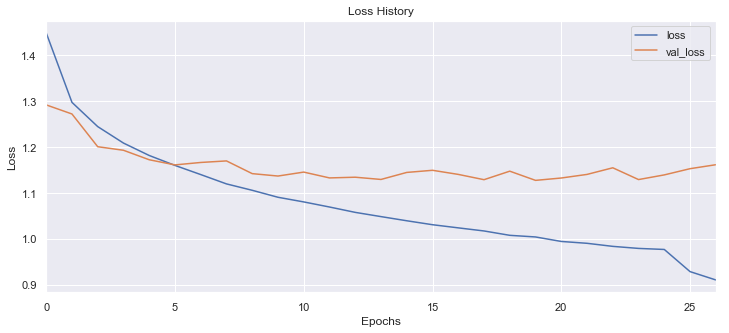

time: 263 ms


In [405]:
summary = pd.DataFrame(history.history)

ax = summary[['loss', 'val_loss']].plot(figsize=(12, 5), title='Loss History')
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');


In [406]:
y_pred = model.predict(devtest_word_sequences)

time: 39.3 s


AUROC: 0.740
MCC: 0.549
              precision    recall  f1-score   support

           1       0.71      0.62      0.66     11749
           2       0.44      0.31      0.36      6701
           3       0.43      0.59      0.49      9611
           4       0.55      0.40      0.46     18145
           5       0.86      0.91      0.89     81696

    accuracy                           0.76    127902
   macro avg       0.60      0.56      0.57    127902
weighted avg       0.75      0.76      0.75    127902



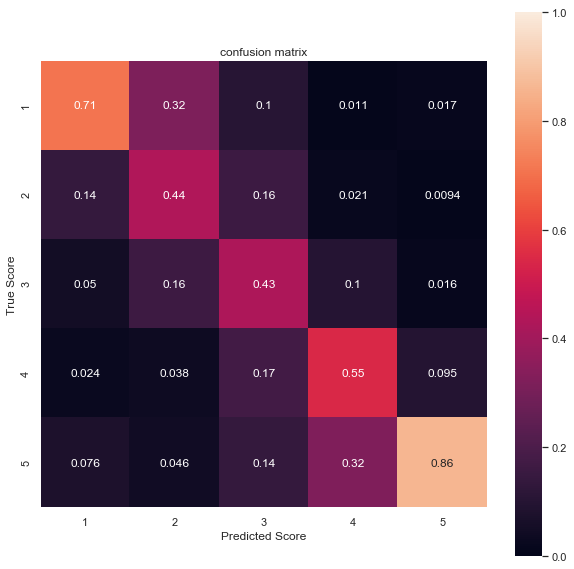

time: 742 ms


In [404]:
report = evaluate_prediction(scores_devtest, y_pred)

In [210]:
report_label = model.name
report_path = REPORTS_DIR / f'{report_label}.json'
if report_path.exists():
    overwrite = input(f'overwrite {report_path}? (Y/N)')
    if overwrite == 'Y':
        save_report(report, REPORTS_DIR, label=report_label)
else:
    save_report(report, REPORTS_DIR, label=report_label)

overwrite ../reports/conv1d-dnn-softmax.json? (Y/N) Y


time: 1.55 s
